<center> <img src="images/HSSM_logo.png"> </center>

This tutorial provides a comprehensive introduction to the HSSM package for Hierarchical Bayesian Estimation of Sequential Sampling Models.

To make the most of the tutorial, let us cover the functionality of the key supporting packages that we use along the way. 

## Colab Instructions

If you would like to run this tutorial on Google colab, please click this [link](https://github.com/lnccbrown/HSSM/blob/main/docs/tutorial_notebooks/no_execute/main_tutorial.ipynb). 

Once you are *in the colab*, follow the *installation instructions below* and then **restart your runtime**. 

Just **uncomment the code in the next code cell** and run it!

**NOTE**:

You may want to *switch your runtime* to have a GPU or TPU. To do so, go to *Runtime* > *Change runtime type* and select the desired hardware accelerator.

Note that if you switch your runtime you have to follow the installation instructions again.

In [ ]:
# !pip install numpy==1.23.4
# !pip install git+https://github.com/lnccbrown/hssm@main
# !pip install git+https://github.com/brown-ccv/hddm-wfpt@main
# !pip install numpyro

## SSMS for Data Simulation

We will rely on the [ssms](https://github.com/AlexanderFengler/ssm-simulators) package for data simulation repeatedly. Let's look at a basic isolated use case below.

As an example, let's use [ssms](https://github.com/AlexanderFengler/ssm-simulators) to simulate from the basic [Drift Diffusion Model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2474742/) (a running example in this tutorial).

<center> <img src="images/DDM_with_params_pic.png" height="400" width="400"> </center>

If you are not familiar with the DDM. For now just consider that it has four parameters. 

- `v` the drift rate
- `a` the boundary separation
- `t` the non-decision time
- `z` the a priori decision bias (starting point)

In [1]:
from ssms.basic_simulators import simulator
import numpy as np
import pandas as pd

# Specify parameters
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.2]


# Simulate data
sim_out = simulator(
    theta=[v_true, a_true, z_true, t_true],  # parameter list
    model="ddm",  # specify model (many are included in ssms)
    n_samples=500,  # number of samples for each set of parameters
)

# Turn into nice dataset
# Turn data into a pandas dataframe
dataset = pd.DataFrame(
    np.column_stack([sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
    columns=["rt", "response"],
)

dataset

,rt,response
0,5.327811,1.0
1,0.911994,1.0
2,1.178991,1.0
3,1.032993,1.0
4,5.305812,1.0
...,...,...
495,2.361026,1.0
496,0.442000,1.0
497,0.919994,1.0
498,1.320996,1.0


We can instead supply a `matrix` (or `array`) of parameters and `ssms`, will know how to handle that too.
This usage makes sense if you e.g. care about *trial-wise* parameterizations. Just supply a matrix of parameters, and set the `n_samples = 1`.

In [2]:
# a changes trial wise
a_true_trialwise = np.random.normal(loc=2, scale=0.3, size=1000)
theta_mat = np.zeros((1000, 4))
theta_mat[:, 0] = v_true
theta_mat[:, 1] = a_true_trialwise
theta_mat[:, 2] = z_true
theta_mat[:, 3] = t_true

# simulate data
sim_out_trialwise = simulator(
    theta=theta_mat,  # parameter_matrix
    model="ddm",  # specify model (many are included in ssms)
    n_samples=1,  # number of samples for each set of parameters
)

# Turn into nice dataset
dataset_trialwise = pd.DataFrame(
    np.column_stack(
        [sim_out_trialwise["rts"][:, 0], sim_out_trialwise["choices"][:, 0]]
    ),
    columns=["rt", "response"],
)

dataset_trialwise

,rt,response
0,4.986835,1.0
1,1.534006,1.0
2,3.523942,1.0
3,2.856990,1.0
4,1.496005,1.0
...,...,...
995,1.535006,-1.0
996,2.607008,1.0
997,10.219419,1.0
998,4.599864,1.0


We will use [ssms](https://github.com/AlexanderFengler/ssm-simulators) throughout the tutorial to generate data, relying on both, the trial-wise parameter matrices and the simple parameter list as natural for the respective example.

## ArviZ for Plotting

<center> <img src="images/arviz.png" height="200" width="200"> </center>


We use the [ArviZ](https://python.arviz.org/en/stable/) package for most of our plotting needs. 
ArviZ is a useful aid for plotting when doing anything Bayesian. 

It works with HSSM out of the box, by virtue of HSSMs reliance on [PyMC](https://www.pymc.io/welcome.html) for model construction and sampling.

Checking out the [ArviZ Documentation](https://python.arviz.org/en/stable/getting_started/index.html) is a good idea to give you communication superpowers for not only your HSSM results, but also other libraries in the Bayesian Toolkit such as [NumPyro](https://num.pyro.ai/en/latest/index.html#introductory-tutorials) or [STAN](https://mc-stan.org/users/documentation/).

We will see [ArviZ](https://python.arviz.org/en/stable/) plots throughout the notebook.  

# Main Tutorial

In [3]:
# Basics
import os
import sys
import time
from matplotlib import pyplot as plt
import arviz as az  # Visualization
import pytensor  # Graph-based tensor library
import hssm

# import ssms.basic_simulators # Model simulators
import hddm_wfpt
import bambi as bmb

# Setting float precision in pytensor
pytensor.config.floatX = "float32"

from jax.config import config

config.update("jax_enable_x64", False)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Initial Dataset

Using our knowledge of [ssms](https://github.com/AlexanderFengler/ssm-simulators), we can proceed to simulate a simple dataset for our first example.

In [4]:
# Specify parameter values
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.2]

# Simulate data
sim_out = simulator([v_true, a_true, z_true, t_true], model="ddm", n_samples=500)

# Turn data into a pandas dataframe
dataset = pd.DataFrame(
    np.column_stack([sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
    columns=["rt", "response"],
)

dataset

,rt,response
0,1.554007,1.0
1,2.647005,1.0
2,2.297030,1.0
3,2.238035,1.0
4,3.209964,1.0
...,...,...
495,0.815996,-1.0
496,5.029832,1.0
497,1.203991,1.0
498,2.094033,1.0


## First HSSM Model

In this example we will use the *analytical likelihood function* computed as suggested in [this paper](https://psycnet.apa.org/record/2009-11068-003).

### Instantiate the model

To instantiate our `HSSM` class, in the simplest version, we only need to provide an appropriate dataset.
The dataset is expected to be a `pandas.DataFrame` with at least two columns, respectively called `rt` (for reaction time) and `response`.
Our data simulated above is already in the correct format, so let us try to construct the class.

**NOTE:**

If you are a user of the [HDDM](https://github.com/hddm-devs/hddm) python package, this workflow should seem very familiar.

In [ ]:
simple_ddm_model = hssm.HSSM(data=dataset)

In [ ]:
print(simple_ddm_model)

The `print()` function gives us some basic information about our model including the *number of observations* the *parameters in the model* and their respective *prior setting*. We can also create a nice little graphical represnetaion of our model...

### Model Graph

Since `HSSM` creates a `PyMC Model`, we can can use the `.graph()` function, to get a graphical representation of the the model we created.

In [ ]:
simple_ddm_model.graph()

This is the simplest model we can build. We have our basic parameters (unobserved, white node), and our observed reaction times and choices (`SSMRandomVariable`, grey node).

The `graph()` function becomes a lot more interesting for more complicated models!

### Sample from the Model

We can now call the `.sample()` function, to get posterior samples. The main arguments you may want to change are listed in the function call below. 
Importantly, multiple backends are possible. We choose the `nuts_numpyro` backend below,
which in turn compiles the model to a [`JAX`](https://github.com/google/jax) function.

In [ ]:
infer_data_simple_ddm_model = simple_ddm_model.sample(
    sampler="nuts_numpyro",  # type of sampler to choose, 'nuts_numpyro', 'nuts_blackjax' of default pymc nuts sampler
    cores=1,  # how many cores to use
    chains=2,  # how many chains to run
    draws=500,  # number of draws from the markov chain
    tune=500,  # number of burn-in samples
    idata_kwargs=dict(log_likelihood=True),  # return log likelihood
)  # mp_ctx="forkserver")

In [ ]:
type(infer_data_simple_ddm_model)

Errr... let's look at this object in a bit more detail!

### Inference Data / What gets returned from the sampler?

The sampler returns an [ArviZ](https://python.arviz.org/en/stable/) `InferenceData` object. 

To understand all the logic behind these objects and how they mesh with the Bayesian Workflow, we refer you to the [ArviZ Documentation](https://python.arviz.org/en/stable/getting_started/index.html).

But let's take a quick high-level look to understand roughly what we are dealing with here!

In [ ]:
infer_data_simple_ddm_model

We see that in our case, `infer_data_simple_ddm_model` contains four basic types of data (note: this is extensible!)

- `posterior`
- `log_likelihood`
- `sample_stats`
- `observed_data`

The `posterior` object contains our traces for each of the parameters in the model. The `log_likelihood` field contains the trial wise log-likelihoods for each sample from the posterior. The `sample_stats` field contains information about the sampler run. This can be important for chain diagnostics, but we will not dwell on this here. Finally we retreive our `observed_data`.


### Making use of ArviZ

We can now start using [ArviZ](https://python.arviz.org/en/stable/) functions. 


#### Summary table

Let's take a look at a summary table for our posterior. 

In [ ]:
az.summary(infer_data_simple_ddm_model)

This table returns the parameter-wise mean of our posterior and a few extra statistics.

Next, we can plot our traces directly.

#### Trace plot

In [ ]:
az.plot_trace(
    infer_data_simple_ddm_model,
    var_names="~log_likelihood",  # we exclude the log_likelihood traces here
)
plt.tight_layout()

The `.sample()` function also sets a `trace` attribute, on our `hssm` class, so instead, we could call the plot like so:

In [ ]:
az.plot_trace(simple_ddm_model.traces);

In this tutorial we are most often going to use the latter way of accessing the traces, but there is no preferred option. 

Let's look at a few more plots.

#### Forest Plot

The forest plot is commonly used for a quick visual check of the marginal posteriors. It is very effective for intuitive communication of results.

In [ ]:
az.plot_forest(simple_ddm_model.traces)

#### Basic Marginal Posterior Plot

Another way to view the marginal posteriors is provided by the `plot_posterior()` function. It shows the mean and by default the $94\%$ HDIs.

In [ ]:
az.plot_posterior(simple_ddm_model.traces)

#### Posterior Pair Plot

The posterior pair plot is useful to check for simple parameter tradeoffs thst may emerge. 

In [ ]:
az.plot_pair(simple_ddm_model.traces, kind="kde")

This is just the beginning: [ArviZ](https://python.arviz.org/en/stable/) has a much broader spectrum of graphs and other convenience function available. Just check the [documentation](https://python.arviz.org/en/stable/). 

## HSSM Model based on LAN likelihood

With HSSM you can switch between pre-supplied models with a simple change of argument. The type of likelihood that will be accessed might change in the background for you. 

Here we see an example in which the underlying likelihood is now a [LAN](https://elifesciences.org/articles/65074).

We will talk more about different types of likelihood functions and backends later in the tutorial. For now just keep the following in mind:

There are three types of likelihoods

1. `analytic`
2. `approx_differentiable`
3. `blackbox`

To check which type is used in your HSSM model simple type:

In [ ]:
simple_ddm_model.loglik_kind

Ah... we were using an `analytical` likelihood with the DDM model in the last section.
Now let's see something different!

### Simulating Angle Data

Again, let us simulate a simple dataset. This time we will use the `angle` model (passed via the `model` argument to the `simulator()` function). 


This model is distinguished from the basic `ddm` model by an additional `theta` parameter which specifies the angle with which the decision boundaries collapse over time.

<center> <img src="images/ANGLE_with_params_pic.png" height="400" width="400"> </center>

DDMs with collapsing bounds have been of significant interest in the theoretical literature, but applications were rare due to a lack of analytical likelihoods. HSSM facilitates inference with such models via the our `approx_differentiable` likelihoods. HSSM ships with a few predefined models based on [LANs](https://elifesciences.org/articles/65074), but really we don't want to overemphasize those. They reflect the research interest of our and adjacent labs to a great extend. 

Instead, we encourage the community to contribute to this model reservoir (more on this later). 

In [ ]:
# Simulate angle data
v_true, a_true, z_true, t_true, theta_true = [0.5, 1.5, 0.5, 0.5, 0.2]
obs_angle = simulator(
    [v_true, a_true, z_true, t_true, theta_true], model="angle", n_samples=1000
)

dataset_angle = pd.DataFrame(
    np.column_stack([obs_angle["rts"][:, 0], obs_angle["choices"][:, 0]]),
    columns=["rt", "response"],
)

We pass a single additional argument to our `HSSM` class and set `model='angle'`. 

In [ ]:
model_angle = hssm.HSSM(data=dataset_angle, model="angle")

model_angle

Let's check the type of likelihood that is used under the hood ...

In [ ]:
model_angle.loglik_kind

Ok so here we rely on a likelihood of the `approx_differentiable` kind. 

As discussed, with the initial set of pre-supplied likelihoods, this implies that we are using a [LAN](https://elifesciences.org/articles/65074) in the background.

In [ ]:
from jax.config import config

config.update("jax_enable_x64", False)
infer_data_angle = model_angle.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=False),  # no need to return likelihoods here
)

In [ ]:
az.plot_trace(model_angle.traces)
plt.tight_layout()

## Choosing Priors

HSSM allows you to specify priors quite freely. If you used HDDM previously, you may feel relieved to read that your hands are now untied!


<center><img src="https://media.giphy.com/media/99uUPYHtmaJS8/giphy.gif" style="margin:auto" height="400" width="400"/></center>

With HSSM we have multiple routes to priors. But let's first consider a special case:

### Fixing a parameter to a given value

Assume that instead of fitting all parameters of the DDM, 

<center> <img src="images/DDM_with_params_pic.png" height="400" width="400"> </center> 

we instead want to fit only the `v` (drift) parameter, setting all other parameters to fixed scalar values.

<center> <img src="images/DDM_only_v_pic.png" height="400" width="400"> </center> 

HSSM makes this extremely easy!

In [ ]:
ddm_model_only_v = hssm.HSSM(data=dataset, model="ddm", a=1.5, t=0.2, z=0.5)

In [ ]:
ddm_model_only_v.graph()

In [ ]:
ddm_model_only_v.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=False),  # no need to return likelihoods here
)

In [ ]:
az.plot_trace(ddm_model_only_v.traces)

### Named priors

We can choose any [PyMC](https://www.pymc.io/welcome.html) `Distribution` to specify a prior for a given parameter. 

Even better, if natural *parameter bounds* are provided, HSSM *automatically truncates the prior distribution* so that it respect these bounds. 

Below is an example in which we specify a *Normal* prior on the `v` parameter of the DDM. 

We choose a *ridiculously low* $\sigma$ value, to illustrate it's regularizing effect on the parameter (just so we see a difference and you are convinced that something changed). 

In [ ]:
model_normal = hssm.HSSM(
    data=dataset,
    include=[
        {
            "name": "v",
            "prior": {"name": "Normal", "mu": 0, "sigma": 0.01},
        }
    ],
)

In [ ]:
model_normal

In [ ]:
infer_data_normal = model_normal.sample(
    sampler="nuts_numpyro",
    chains=2,
    cores=2,
    draws=500,
    tune=500,
    idata_kwargs=dict(log_likelihood=False),  # no need to return likelihoods here
)

In [ ]:
az.plot_trace(model_normal.traces)

Observe how we reused our previous dataset with underlying parameters 

- `v = 0.5`
- `a = 1.5`
- `z = 0.5`
- `t = 0.2`

In contrast to our previous sampler round, in which we used Uniform priors, here the `v` estimate is shrunk severley towared $0$ and the `t` and `z` parameter estimates are very biased to make up for this distortion.

## HSSM Model with Regression


<center> <img src="images/bambi.png" height="200" width="200"> </center>

Crucial to the scope of HSSM is the ability to link parameters with trial-by-trial covariates via (hierarchical, but more on this later) general linear models. 
 
In this section we explore how HSSM deals with these models. No big surprise here... it's simple!

### Case 1: One parameter is a Regression Target 

#### Simulating Data

Let's first simulate some data, where the trial-by-trial parameters of the `v` parameter in our model are driven by a simple linear regression model.


The regression model is driven by two (random) covariates `x` and `y`, respectively with coefficients of $0.8$ and $0.3$ which are also simulated below.
We set the intercept to $0.3$.

The rest of the parameters are fixed to single values as before.

In [5]:
# Set up trial by trial parameters
intercept = 0.3
x = np.random.uniform(-1, 1, size=1000)
y = np.random.uniform(-1, 1, size=1000)
v = intercept + (0.8 * x) + (0.3 * y)

true_values = np.column_stack(
    [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=1000)]
)

In [6]:
# Get mode simulations
obs_ddm_reg_v = simulator(true_values, model="ddm", n_samples=1)

dataset_reg_v = pd.DataFrame(
    {
        "rt": obs_ddm_reg_v["rts"].flatten(),
        "response": obs_ddm_reg_v["choices"].flatten(),
        "x": x,
        "y": y,
    }
)

dataset_reg_v

,rt,response,x,y
0,1.268994,1,0.965303,-0.760180
1,2.312029,1,0.515460,-0.634712
2,1.229994,1,-0.485347,-0.033517
3,2.079018,1,0.096547,0.908745
4,4.213913,1,0.254733,0.087920
...,...,...,...,...
995,1.377992,1,-0.296970,-0.498866
996,4.066924,1,-0.550556,0.687968
997,3.712950,-1,-0.656432,-0.822864
998,3.801943,-1,-0.729457,-0.004827


We now create the `HSSM` model. 

Notice how we set the `include` argument. The include argument expects a list of dictionaries, one dictionary for each parameter to be specified via a regression model. 

Four `keys` are expected to be set:

- The `name` of the parameter, 
- Potentially a `prior` for each of the regression level parameters ($\beta$'s), 
- The regression `formula` 
- A `link` function. 

The regression formula follows the syntax in the [formulae](https://pypi.org/project/formulae/) python package (as used by the [Bambi](https://bambinos.github.io/bambi/) package for building Bayesian Hierarchical Regression Models. 

[Bambi](https://bambinos.github.io/bambi/) forms the main model-construction backend of HSSM.

In [7]:
model_reg_v = hssm.HSSM(
    data=dataset_reg_v,
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)

In [8]:
model_reg_v

Hierarchical Sequential Sampling Model
Model: ddm

Response variable: rt,response
Likelihood: analytical
Observations: 1000

Parameters:

v:
    Formula: v ~ 1 + x + y
    Priors:
        v_Intercept ~ Uniform(lower: -3.0, upper: 3.0)
        v_x ~ Uniform(lower: -1.0, upper: 1.0)
        v_y ~ Uniform(lower: -1.0, upper: 1.0)
    Link: identity
    Explicit bounds: (-inf, inf)
a:
    Prior: HalfNormal(sigma: 2.0)
    Explicit bounds: (0.0, inf)
z:
    Prior: Uniform(lower: 0.0, upper: 1.0)
    Explicit bounds: (0.0, 1.0)
t:
    Prior: Uniform()
    Explicit bounds: (0.0, inf)

Lapse probability: 0.05
Lapse distribution: Uniform(lower: 0.0, upper: 10.0)

Notice how `v` is now set as a regression.

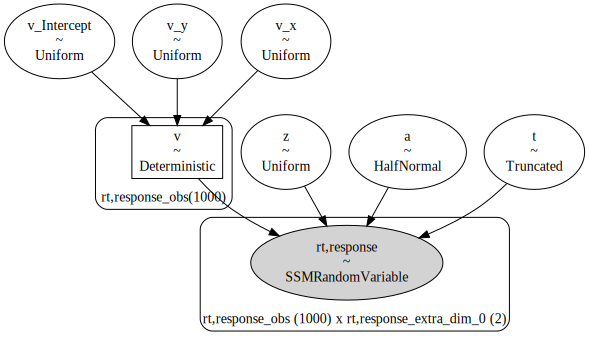

In [9]:
model_reg_v.graph()

In [10]:
infer_data_reg_v = model_reg_v.sample(
    sampler="nuts_numpyro", chains=1, cores=1, draws=500, tune=500
)

Compiling...


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Compilation time =  0:01:01.149160
Sampling...


/opt/conda/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/opt/conda/lib/python3.9/site-packages/pytensor/link/jax/dispatch/tensor_basic.py:177: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x, dtype=op.dtype)
sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000

Sampling time =  0:00:18.003299
Transforming variables...
Transformation time =  0:00:00.247577


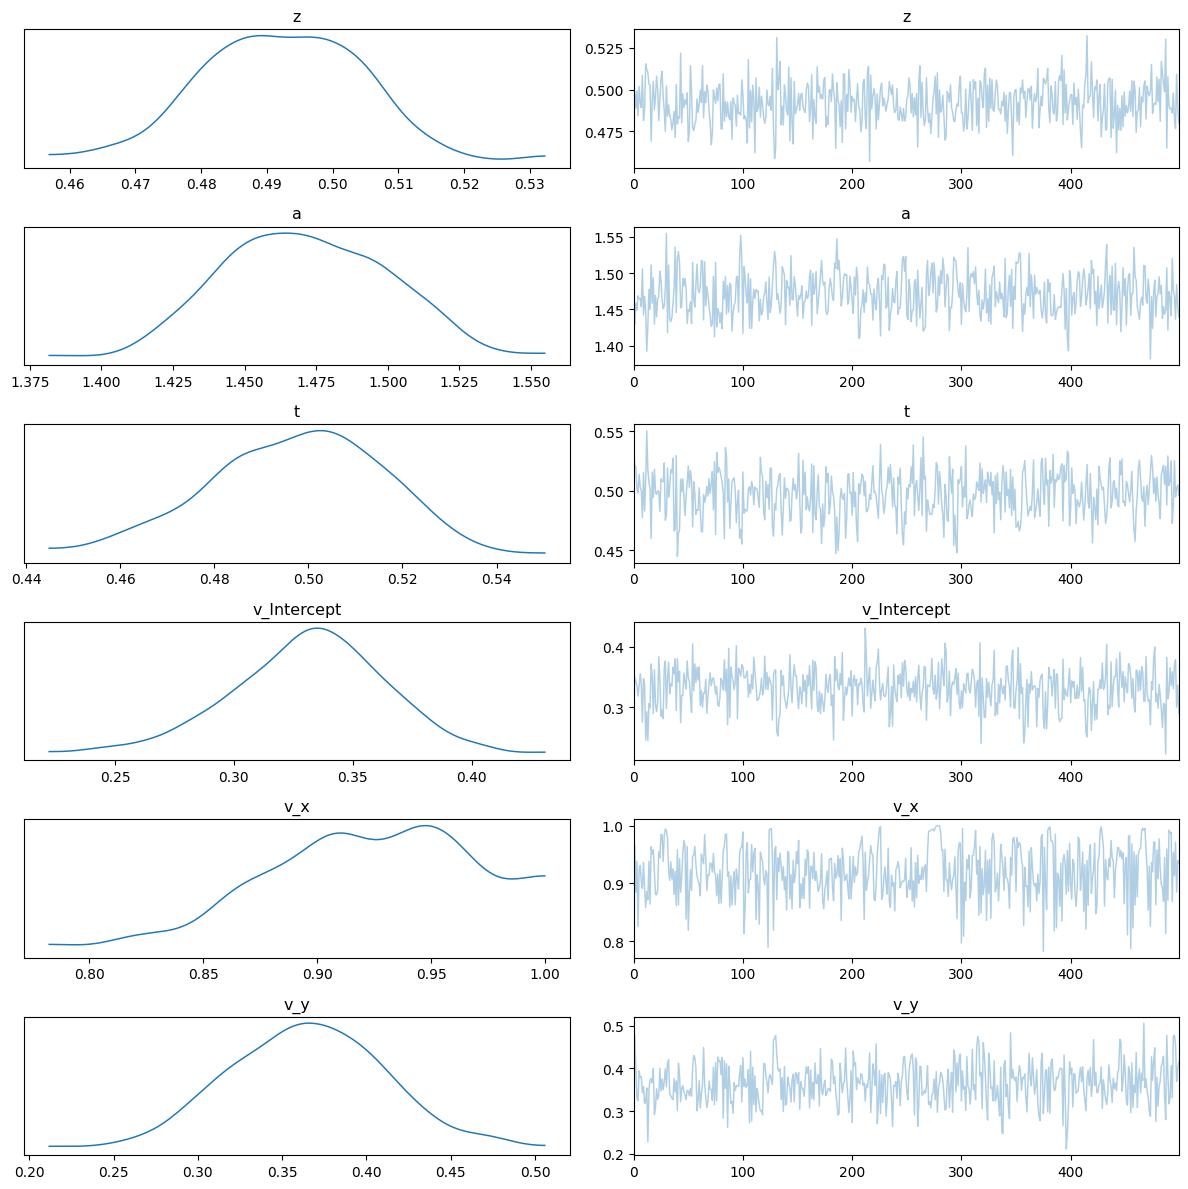

In [11]:
az.plot_trace(model_reg_v.traces)
plt.tight_layout()

In [12]:
# Looks like parameter recovery was successful
az.summary(model_reg_v.traces)

arviz - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.492,0.012,0.470,0.514,0.001,0.000,552.0,472.0,NaN
a,1.471,0.029,1.420,1.520,0.002,0.001,347.0,296.0,NaN
t,0.497,0.018,0.463,0.530,0.001,0.001,340.0,333.0,NaN
v_Intercept,0.331,0.032,0.265,0.385,0.002,0.001,407.0,308.0,NaN
v_x,0.921,0.045,0.851,1.000,0.002,0.002,240.0,142.0,NaN
v_y,0.365,0.047,0.276,0.449,0.002,0.002,444.0,309.0,NaN


### Case 2: One parameter is a Regression (LAN)

We can do the same thing with the `angle` model.

**Note**: 

Our dataset was generated from the basic DDM here, so since the DDM assumes stable bounds, we expect the `theta` (angle of linear collapse) parameter to be recovered as close to $0$.

In [13]:
model_reg_v_angle = hssm.HSSM(
    data=dataset_reg_v,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    # "initval": 0   # optional --> set the initial value of the parameter (to e.g. avoid boundary violations at the intial sampling step)
                },
                "x": {
                    "name": "Uniform",
                    "lower": -1.0,
                    "upper": 1.0,
                },
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
            "link": "identity",
        }
    ],
)

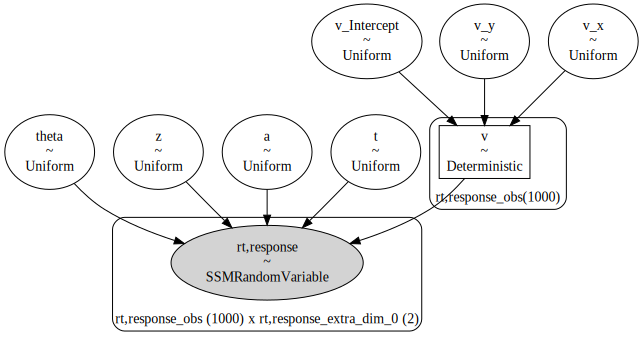

In [14]:
model_reg_v_angle.graph()

In [15]:
trace_reg_v_angle = model_reg_v_angle.sample(
    sampler="nuts_numpyro", chains=1, cores=1, draws=500, tune=500
)

Compiling...
Compilation time =  0:00:08.117471
Sampling...


/opt/conda/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/opt/conda/lib/python3.9/site-packages/pytensor/link/jax/dispatch/tensor_basic.py:177: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x, dtype=op.dtype)
sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 

Sampling time =  0:00:39.427818
Transforming variables...
Transformation time =  0:00:00.167632


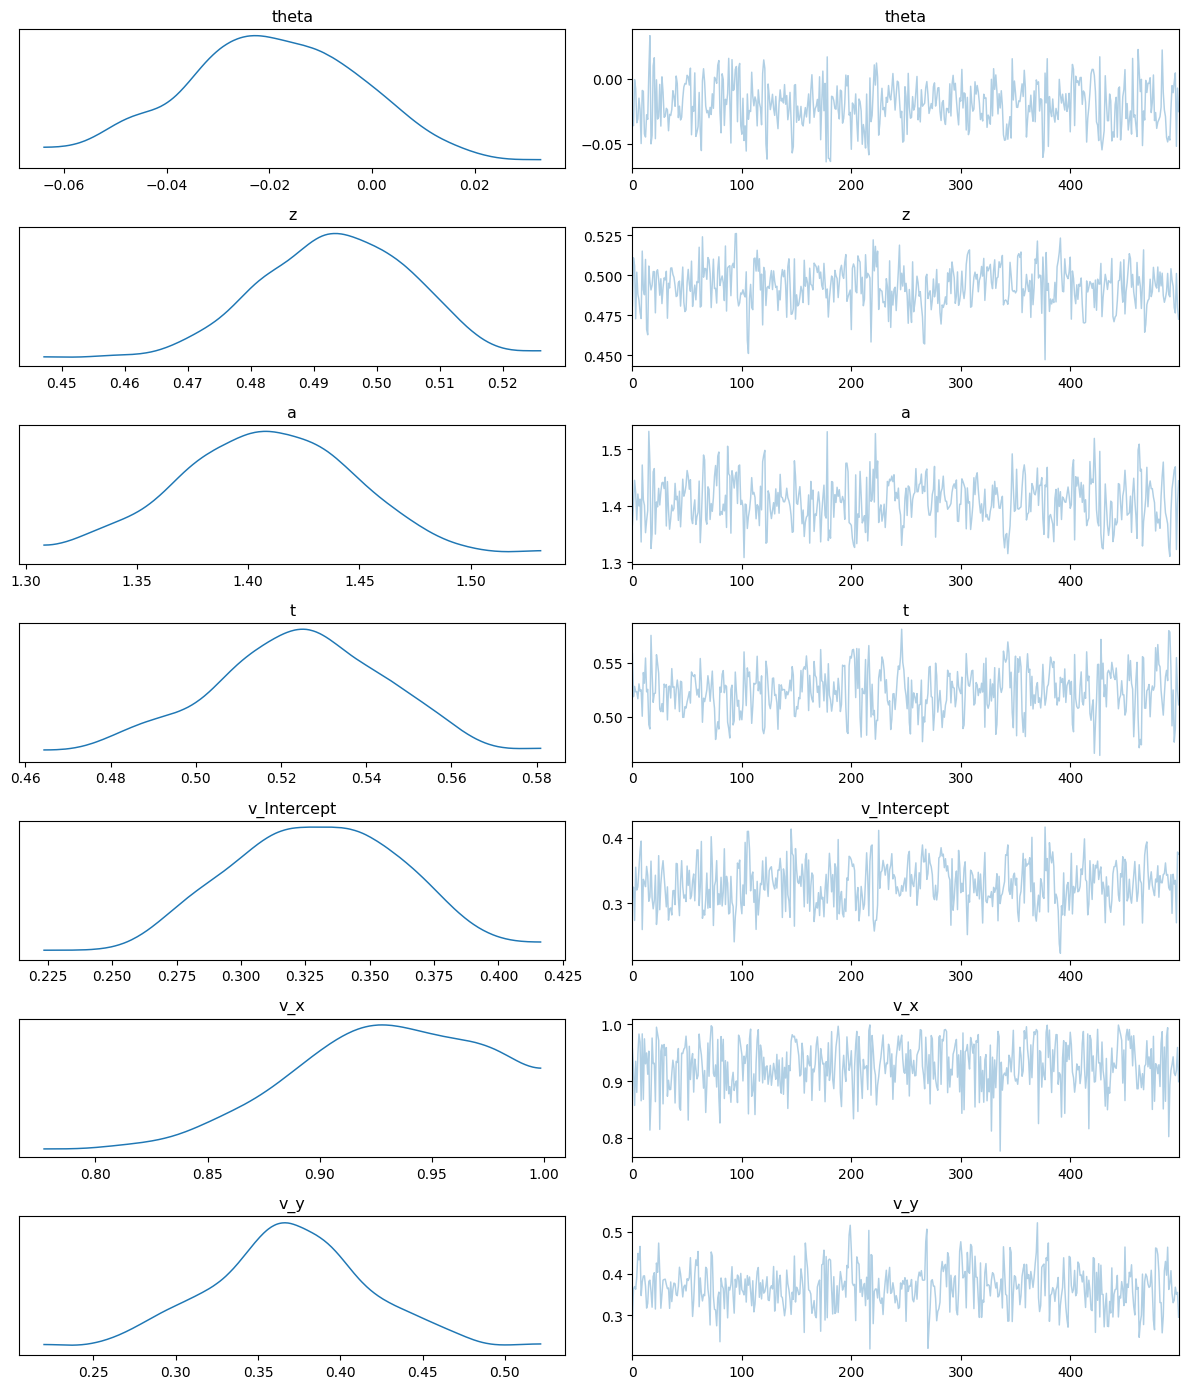

In [16]:
az.plot_trace(model_reg_v_angle.traces)
plt.tight_layout()

Great! `theta` is recovered correctly, on top of that, we have good recovery for all other parameters!

### Case 3: Multiple Parameters are Regression Targets (LAN) 

Let's get a bit more ambitious. We may, for example, want to try a regression on a few of our basic model parameters at once. Below we show an example where we model both the `a` and the `v` parameters with a regression.

**NOTE:**

In our dataset of this section, only `v` is *actually* driven by a trial-by-trial regression, so we expect the regression coefficients for `a` to hover around $0$ in our posterior.

In [17]:
# Instantiate our hssm model
hssm_reg_v_a_angle = hssm.HSSM(
    data=dataset_reg_v,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": -3.0, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
            },
            "formula": "v ~ 1 + x + y",
        },
        {
            "name": "a",
            "prior": {
                "Intercept": {"name": "Uniform", "lower": 0.5, "upper": 3.0},
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0},
            },
            "formula": "a ~ 1 + x + y",
        },
    ],
)

In [18]:
hssm_reg_v_a_angle

Hierarchical Sequential Sampling Model
Model: angle

Response variable: rt,response
Likelihood: approx_differentiable
Observations: 1000

Parameters:

v:
    Formula: v ~ 1 + x + y
    Priors:
        v_Intercept ~ Uniform(lower: -3.0, upper: 3.0)
        v_x ~ Uniform(lower: -1.0, upper: 1.0)
        v_y ~ Uniform(lower: -1.0, upper: 1.0)
    Link: identity
    Explicit bounds: (-3.0, 3.0)
a:
    Formula: a ~ 1 + x + y
    Priors:
        a_Intercept ~ Uniform(lower: 0.5, upper: 3.0)
        a_x ~ Uniform(lower: -1.0, upper: 1.0)
        a_y ~ Uniform(lower: -1.0, upper: 1.0)
    Link: identity
    Explicit bounds: (0.3, 3.0)
z:
    Prior: Uniform(lower: 0.10000000149011612, upper: 0.8999999761581421)
    Explicit bounds: (0.1, 0.9)
t:
    Prior: Uniform(lower: 0.0010000000474974513, upper: 2.0)
    Explicit bounds: (0.001, 2.0)
theta:
    Prior: Uniform(lower: -0.10000000149011612, upper: 1.2999999523162842)
    Explicit bounds: (-0.1, 1.3)

Lapse probability: 0.05
Lapse distribution

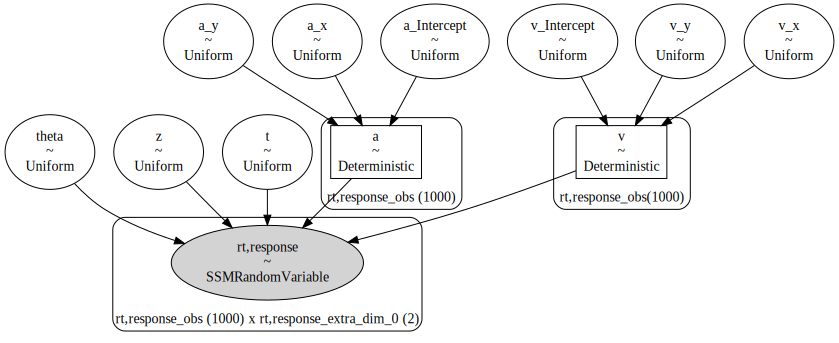

In [19]:
hssm_reg_v_a_angle.graph()

In [20]:
infer_data_reg_v_a = hssm_reg_v_a_angle.sample(
    sampler="nuts_numpyro", chains=2, cores=1, draws=1000, tune=1000
)

Compiling...
Compilation time =  0:00:04.283778
Sampling...


/opt/conda/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/opt/conda/lib/python3.9/site-packages/pytensor/link/jax/dispatch/tensor_basic.py:177: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x, dtype=op.dtype)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:01:16.330452
Transforming variables...
Transformation time =  0:00:00.951145


In [28]:
# az.summary(infer_data_reg_v_a, var_names=["~rt,response_obs"])
az.summary(infer_data_reg_v_a, var_names=["~a"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,-0.020,0.018,-0.057,0.011,0.001,0.000,904.0,915.0,1.0
z,0.495,0.012,0.473,0.517,0.000,0.000,1686.0,1486.0,1.0
t,0.525,0.020,0.486,0.562,0.001,0.000,1082.0,1047.0,1.0
v_Intercept,0.329,0.033,0.266,0.388,0.001,0.001,1680.0,1533.0,1.0
v_x,0.928,0.044,0.851,1.000,0.001,0.001,1132.0,566.0,1.0
v_y,0.377,0.045,0.285,0.454,0.001,0.001,1978.0,1301.0,1.0
a_Intercept,1.411,0.039,1.339,1.484,0.001,0.001,925.0,969.0,1.0
a_x,-0.019,0.041,-0.094,0.057,0.001,0.001,1671.0,1025.0,1.0
a_y,0.078,0.037,0.010,0.147,0.001,0.001,1991.0,1465.0,1.0


We successfully recover our regression betas for `a`! Moreover, no warning signs concerning our chains.

## Hierarchical Inference

Let's try to fit a hierarchical model now. We will simulate a dataset with $15$ participants, with $200$ observations / trials for each participant. 

We define a group mean `mean_v` and a group standard deviation `sd_v` for the intercept parameter of the regression on `v`, which we sample from a corresponding normal distribution for each subject.

### Simulate Data

In [29]:
# Make some hierarchical data

n_subjects = 15  # number of subjects
n_trials = 200  # number of trials per subject

sd_v = 0.5  # sd for v-intercept
mean_v = 0.5  # mean for v-intercept

data_list = []
for i in range(n_subjects):
    # Make parameters for subject i
    intercept = np.random.normal(mean_v, sd_v, size=1)
    x = np.random.uniform(-1, 1, size=n_trials)
    y = np.random.uniform(-1, 1, size=n_trials)
    v = intercept + (0.8 * x) + (0.3 * y)

    true_values = np.column_stack(
        [v, np.repeat([[1.5, 0.5, 0.5, 0.0]], axis=0, repeats=n_trials)]
    )

    # Simulate data
    obs_ddm_reg_v = simulator(true_values, model="ddm", n_samples=1)

    # Append simulated data to list
    data_list.append(
        pd.DataFrame(
            {
                "rt": obs_ddm_reg_v["rts"].flatten(),
                "response": obs_ddm_reg_v["choices"].flatten(),
                "x": x,
                "y": y,
                "subject": i,
            }
        )
    )

# Make single dataframe out of subject-wise datasets
dataset_reg_v_hier = pd.concat(data_list)
dataset_reg_v_hier

,rt,response,x,y,subject
0,2.097019,-1,-0.642096,-0.990798,0
1,1.711001,-1,0.573196,-0.961609,0
2,1.241994,1,0.158319,0.659311,0
3,1.539993,-1,-0.813278,-0.831820,0
4,0.829999,1,0.391415,0.020249,0
...,...,...,...,...,...
195,1.603996,1,-0.505634,0.982519,14
196,1.417992,1,-0.060074,-0.366571,14
197,1.310993,1,0.054054,-0.788935,14
198,1.342993,-1,-0.514017,-0.440648,14


We can now define our `HSSM` model. 

We specify the regression as `v ~ 1 + (1|subject) + x + y`. 

`(1|subject)` tells the model to create a *subject-wise* offset for the intercept parameter. The rest of the regression $\beta$'s is fit globally. 

As an **R** user you may recognize this syntax from the [lmer](https://www.rdocumentation.org/packages/lme4/versions/1.1-33/topics/lmer) package. 

Our [Bambi](https://bambinos.github.io/bambi/) backend is essentially a Bayesian version of [lmer](https://www.rdocumentation.org/packages/lme4/versions/1.1-33/topics/lmer), quite like the [BRMS](https://cran.r-project.org/web/packages/brms/index.html) package in **R**, which operates on top of [STAN](https://mc-stan.org/). 

As a previous [HDDM](https://hddm.readthedocs.io/en/latest/) user, you may recognize that now proper mixed-effect models are viable! 

You should be able to handle between and within subject effects naturally now!


In [30]:
model_reg_v_angle_hier = hssm.HSSM(
    data=dataset_reg_v_hier,
    model="angle",
    include=[
        {
            "name": "v",
            "prior": {
                "Intercept": {
                    "name": "Uniform",
                    "lower": -3.0,
                    "upper": 3.0,
                    "initval": 0.0,
                },
                "x": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
                "y": {"name": "Uniform", "lower": -1.0, "upper": 1.0, "initval": 0.0},
            },
            "formula": "v ~ 1 + (1|subject) + x + y",
            "link": "identity",
        }
    ],
)

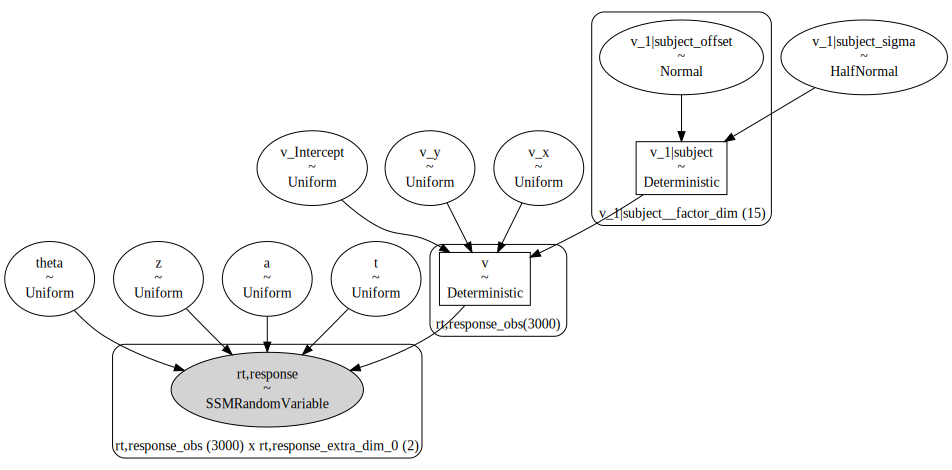

In [31]:
model_reg_v_angle_hier.graph()

In [32]:
from jax.config import config

config.update("jax_enable_x64", False)
model_reg_v_angle_hier.sample(
    sampler="nuts_numpyro", chains=2, cores=1, draws=1000, tune=1000
)

Compiling...
Compilation time =  0:00:14.904250
Sampling...


/opt/conda/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:796: UserWarning: Explicitly requested dtype float64 requested in astype is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/opt/conda/lib/python3.9/site-packages/pytensor/link/jax/dispatch/tensor_basic.py:177: UserWarning: Explicitly requested dtype float64 requested in array is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return jnp.array(x, dtype=op.dtype)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:08:30.274279
Transforming variables...
Transformation time =  0:00:00.238040


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

Let's look at the posteriors!

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

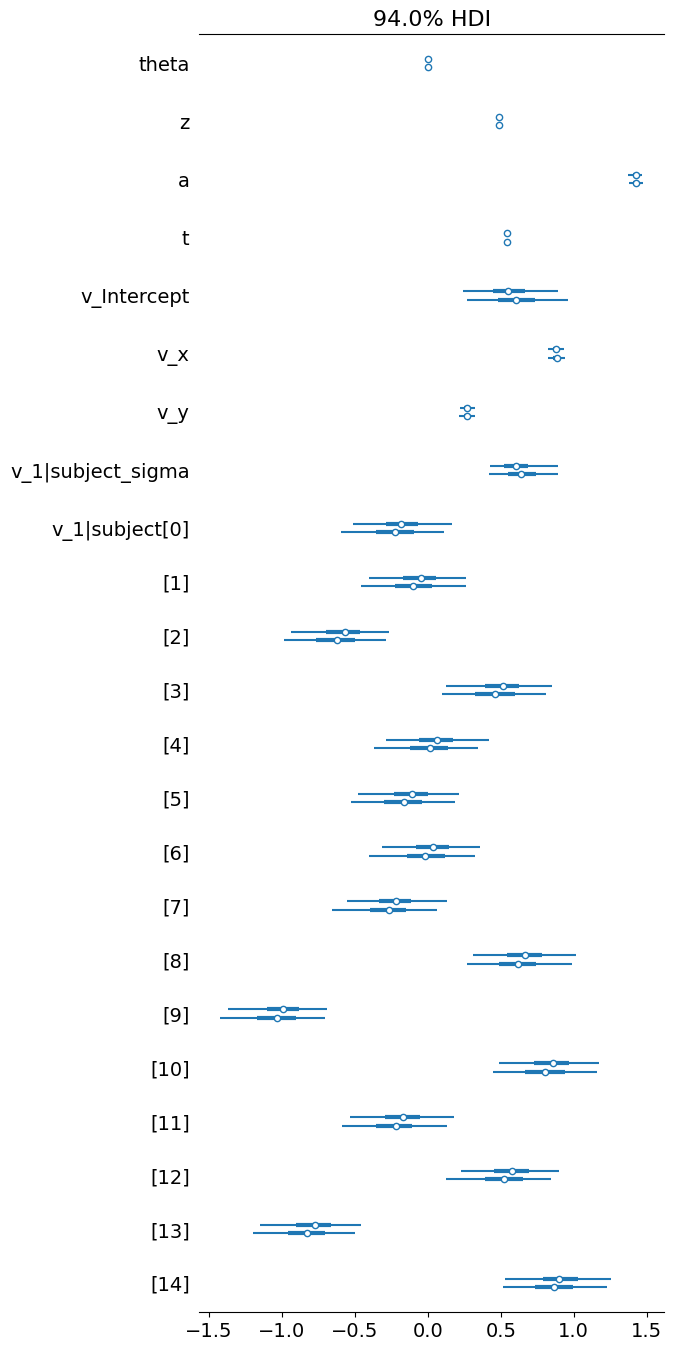

In [33]:
az.plot_forest(model_reg_v_angle_hier.traces)

## Model Comparison

Fitting single models is all well and good. We are however, often interested in comparing how well a few different models account for the same data. Again, through [ArviZ](https://python.arviz.org/en/stable/index.html), we have all we need for modern Bayesian Model Comparison. We will keep it simple here, just to illustrate the basic idea. The following scenario is explored. 

First we generate data from a `ddm` model with fixed parameters, specifically we set the `a` parameter to $1.5$. 

We then define two `HSSM` models:

1. A model which allows fitting all but the `a` parameter, which is fixed to $1.0$ (wrong)
2. A model which allows fitting all but the `a` parameter, which is fixed to $1.5$ (correct)

We then use the [ArviZ](https://python.arviz.org/en/stable/index.html)'s `compare()` function, to perform model comparison via `elpd_loo`. 

### Data Simulation

In [ ]:
# Specify parameter values
# Note 'a' is set to 1.5
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.2]

# Simulate data
sim_out = simulator([v_true, a_true, z_true, t_true], model="ddm", n_samples=500)

# Turn data into a pandas dataframe
dataset_model_comp = pd.DataFrame(
    np.column_stack([sim_out["rts"][:, 0], sim_out["choices"][:, 0]]),
    columns=["rt", "response"],
)

print(dataset_model_comp)

### Defining the Models

In [ ]:
# 'wrong' model
model_model_comp_1 = hssm.HSSM(
    data=dataset_model_comp,
    model="angle",
    a=1.0,
)

In [ ]:
# 'correct' model
model_model_comp_2 = hssm.HSSM(
    data=dataset_model_comp,
    model="angle",
    a=1.5,
)

In [ ]:
infer_data_model_comp_1 = model_model_comp_1.sample(
    sampler="nuts_numpyro",
    cores=1,
    chains=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(
        log_likelihood=True
    ),  # model comparison metrics usually need this!
)

In [ ]:
infer_data_model_comp_2 = model_model_comp_2.sample(
    sampler="nuts_numpyro",
    cores=1,
    chains=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(
        log_likelihood=True
    ),  # model comparison metrics usually need this!
)

### Compare

In [ ]:
compare_data = az.compare(
    {
        "a_fixed_1(wrong)": model_model_comp_1.traces,
        "a_fixed_1.5(correct)": model_model_comp_2.traces,
    }
)

compare_data

Notice how the posterior weight on the `correct` model is close to (or equal to ) $1$ here. 
In other words model comparison points us to the correct model with 
a very high degree of certainty here!


We can also use the `.plot_compare()` function to illustrate the model comparison visually.

In [ ]:
az.plot_compare(compare_data)

## But what 'is' a Model in HSSM really?

<center> <img src="images/pytensor_jax.png" height="400" width="400"> </center>

Ok we have seen a few examples of HSSM models at this point. Add a model via a string, maybe toy a bit with with the priors and set regression functions for a given parameter. Turn it hierarchical...  In this section we peel back the onion a bit more to understand better what is going on under the hood. 

After all, we want to encourage you to contribute models to the package yourself. 

Let's first take a little bit of a closer look into the `model_config` dictionaries that define model properties for us. Again let's start with the DDM.

In [ ]:
hssm.config.default_model_config["ddm"].keys()

The dictionary has two high level keys. 

1. `analytical`
2. `approx_differentiable`

These refer to two different types of likelihood that we have available for the `ddm` model.

Our `analytical` likelihood, which goes back to a standard algorithm designed by [Navarro & Fuss](2009). This is the likelihood which was used in the [HDDM](lnccbrown.github.io/HSSM) python toolbox.

Let's expand the dictionary contents:

In [ ]:
hssm.config.default_model_config["ddm"]["analytical"]

We see three properties (key) in this dictionary, of which two are essential:

- The `loglik` field, which points to the likelihood function
- The `bounds` field, which specifies bounds on a subset of the model parameters
- The `default_priors` field, which specifies parameter wise priors

If you provide `bounds` for a parameter, but no `default_priors`, a *Uniform* prior that respects the specified bounds will be applied. 

Next, let's look at the `approx_differentiable` part. 
The likelihood in this part is based on a [LAN]() which was available in [HDDM]() through the [LAN extension](). 

In [ ]:
hssm.config.default_model_config["ddm"]["approx_differentiable"]

We see that the `loglik` field is now a string that points to a `.onnx` file. 
[Onnx](https://onnx.ai/) is a meta framework for Neural Network specification, that allows translation between deep learning Frameworks. This is the preferred format for the neural networks we store in our model reservoir on [HuggingFace](https://huggingface.co/).

Moreover notice that we now have a `backend` field. We allow for two primary backends in the `approx_differentiable` field. 

1. `pytensor`
2. `jax` 

The `jax` backend assumes that your likelihood is described as a jax function, the `pytensor` backend assumes that your likelihood is described as a `pytensor` function. Ok not that surprising...

We won't dwell on this here, however the key idea is to provide users with a large degree of flexibility in describing their likelihood functions and moreover to allow targeted optimization towards MCMC sampler types that [PyMC]() allows us to access.

You can find a [dedicated tutorial](https://lnccbrown.github.io/HSSM/tutorial_likelihoods/#3-kinds-of-likelihoods) in the documentation, which describes the different likelihoods in much more detail. 

Instead, let's take a quick look at how these newfound insights can be used for custom model definition. 

In [ ]:
hssm_alternative_model = hssm.HSSM(
    data=dataset,
    model="ddm",
    loglik_kind="approx_differentiable",
)

In [ ]:
hssm_alternative_model.loglik_kind

In this case we actually built the model class with an `approx_differentiable` LAN likelihood, instead of the default `analytical` likelihood we used in the beginning of the tutorial. The assumed generative model remains the `ddm` however!

In [ ]:
hssm_alternative_model.sample(
    sampler="nuts_numpyro",
    cores=1,
    chains=2,
    draws=1000,
    tune=1000,
    idata_kwargs=dict(
        log_likelihood=False
    ),  # model comparison metrics usually need this!
)

In [ ]:
az.plot_forest(hssm_alternative_model.traces)

We can take this further and specify a completely custom likelihood. See the [dedicated tutorial](https://lnccbrown.github.io/HSSM/tutorial_likelihoods/#using-custom-likelihoods) for more examples!

We will see one specific example below to illustrate another type of likelihood function we have available for model building in HSSM, the *Blackbox* likelihood. 

## 'Blackbox' Likelihoods

<center> <img src="images/blackbox.png" height="400" width="400"> </center>

### What is a **Blackbox Likelihood Function**?

A *Blackbox Likelihood Function* is essentially any Python `callable` (function) that provides trial by trial likelihoods for your model of interest. What kind of computations are performed in this Python function is completely arbitrary. 

E.g. you could built a function that performs forward simulation from you model, constructs are kernel-density estimate for the resulting likelihood functions and evaluates your datapoints on this ad-hoc generated approximate likelihood.

What I just described is a once state-of-the-art method of performing simulation based inference on Sequential Sampling models, a precursor to LANs if you will.

We will do something simpler to keep it short and sweet, but really... the possibilities are endless!

<br> </br>
<center><img src="https://media.giphy.com/media/juq2OXONntuHfLc4Tn/giphy.gif" style="margin:auto" height="300" width="300"/></center>
<br> </br>


### Simulating simple dataset from the DDM

As always, let's begin by generating some simple dataset. 

In [34]:
# Set parameters
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.5, 0.5]

# Generate observations (rts, choices)
obs_ddm = simulator([v_true, a_true, z_true, t_true], model="ddm", n_samples=1000)
dataset = pd.DataFrame(
    np.column_stack([obs_ddm["rts"][:, 0], obs_ddm["choices"][:, 0]]),
    columns=["rt", "response"],
)

dataset

,rt,response
0,2.861011,1.0
1,1.069996,1.0
2,2.084018,-1.0
3,2.873010,1.0
4,2.480036,1.0
...,...,...
995,6.423753,1.0
996,0.764000,1.0
997,2.742020,1.0
998,2.248026,1.0


### Define the likelihood

Now the fun part... we simply define a Python function `my_blackbox_loglik` which takes in our `data` as well as a bunch of model parameters (in our case the familiar `v`,`a`, `z`, `t` from the DDM).

The function then does some arbitrary computation inside (in our case e.g. we pass the data and parameters to the DDM log-likelihood from our predecessor package HDDM).


In [35]:
def my_blackbox_loglik(data, v, a, z, t, err=1e-8):
    data = data[:, 0] * data[:, 1]
    # Our function expects inputs as float64, but they are not guaranteed to
    # come in as such --> we type convert
    return hddm_wfpt.wfpt.pdf_array(
        np.float64(data),
        np.float64(v),
        0,
        np.float64(2 * a),
        np.float64(z),
        0,
        np.float64(t),
        0,
        err,
        1,
    )

### Define HSSM class with our Blackbox Likelihood

We can now define our HSSM model class as usual, however passing our `my_blackbox_loglik()` function to the `loglik` argument, and passing as `loglik_kind = blackbox`. 

The rest of the model config is as usual. Here we can reuse our `ddm` model config, and simply specify bounds on the parameters (e.g. your Blackbox Likelihood might be trustworthy only on a restricted parameters space). 

In [36]:
model = hssm.HSSM(
    data=dataset,
    model="ddm",
    loglik=my_blackbox_loglik,
    loglik_kind="blackbox",
    model_config={
        "bounds": {
            "v": (-10.0, 10.0),
            "a": (0.5, 5.0),
            "z": (0.0, 1.0),
        }
    },
    t=bmb.Prior("Uniform", lower=0.0, upper=2.0, initval=0.1),
)

In [37]:
sample = model.sample()

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [z]
>Slice: [a]
>Slice: [t]
>Slice: [v]


/tmp/ipykernel_274/1138958324.py:5: RuntimeWarning: divide by zero encountered in log
  return hddm_wfpt.wfpt.pdf_array(


/tmp/ipykernel_274/1138958324.py:5: RuntimeWarning: divide by zero encountered in log
  return hddm_wfpt.wfpt.pdf_array(
Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 17 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


**NOTE**:

Since *Blackbox likelihood functions* are assumed to not be differentiable, our default sampler for such likelihood functions is a `Slice` sampler. HSSM allows you to choose any other suitable sampler from the PyMC package instead. A bunch of options are available for grdient-free samplers.

### Results

In [38]:
az.summary(sample)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
z,0.483,0.014,0.456,0.508,0.001,0.000,524.0,814.0,1.0
a,1.490,0.029,1.436,1.544,0.001,0.001,674.0,1097.0,1.0
t,0.536,0.023,0.489,0.576,0.001,0.001,544.0,886.0,1.0
v,0.602,0.035,0.536,0.667,0.001,0.001,598.0,962.0,1.0


array([[<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>]],
      dtype=object)

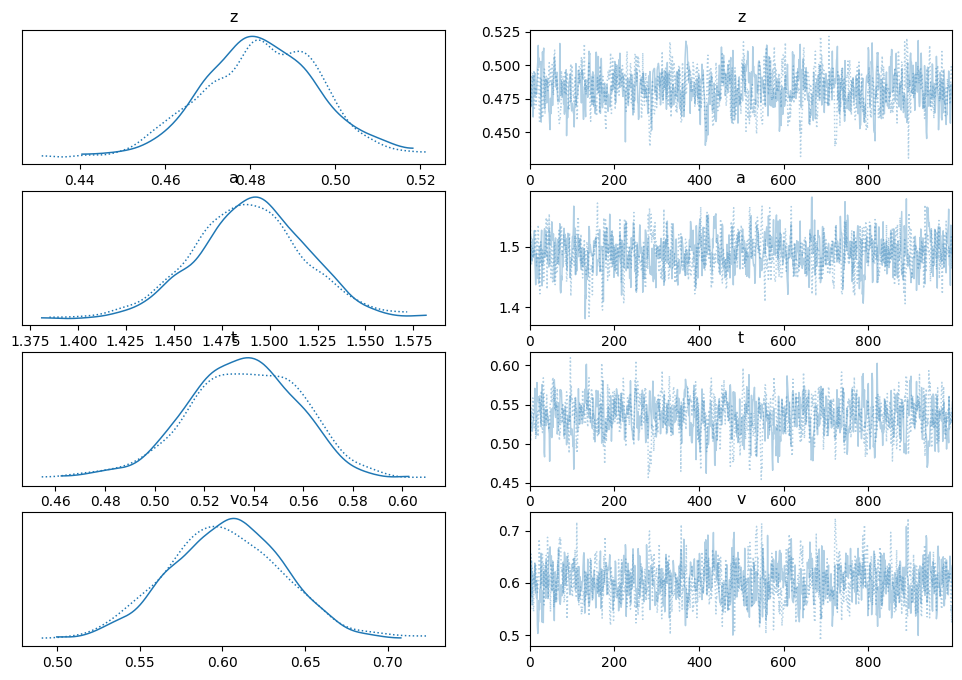

In [39]:
az.plot_trace(sample)

## HSSM Random Variables in PyMC

We covered a lot of ground in this tutorial so far. You are now a sophisticated HSSM user. 

It is therefore time to reveal a secret. We can actuallly peel back on more layer...
<br> </br>
<center><img src="https://media.giphy.com/media/3o6EhKIVvdhTkvjT8s/giphy.gif" style="margin:auto" height="300" width="300"/></center>
<br> </br>

Instead of letting HSSM help you build the entire model, we can instead use HSSM to construct valid [PyMC](https://www.pymc.io/welcome.html) distributions and then proceed to build a custom PyMC model by ourselves...
<br> </br>
<center><img src="https://media.giphy.com/media/3pDxFfu5yZblPUVnWY/giphy.gif" style="margin:auto" height="300" width="300"/></center>
<br> </br>

We will illustrate the simplest example below. It sets a pattern that can be exploited for much more complicated modeling exercises, which importantly go far beyond what our basic HSSM class may facilitate for you! 

See the [dedicated tutorial](https://lnccbrown.github.io/HSSM/notebooks/pymc/) in the [documentation](https://lnccbrown.github.io/HSSM/) if you are interested.

Let's start by importing a few convenience functions:

In [40]:
from hssm.distribution_utils import (
    make_distribution,  # A general function for making Distribution classes
    make_distribution_from_onnx,  # Makes Distribution classes from onnx files
    make_distribution_from_blackbox,  # Makes Distribution classes from callables
)

# pm.Distributions that represents the top-level distribution for
# DDM models (the Wiener First-Passage Time distribution)
from hssm.likelihoods import logp_ddm_sdv, DDM

### Simulate some data

In [41]:
v_true, a_true, z_true, t_true = [0.5, 1.5, 0.2, 0.5]

obs_ddm_pymc = simulator([v_true, a_true, z_true, t_true], model="ddm", n_samples=1000)

dataset_pymc = pd.DataFrame(
    np.column_stack([obs_ddm_pymc["rts"][:, 0], obs_ddm_pymc["choices"][:, 0]]),
    columns=["rt", "response"],
)

### Build a custom PyMC Model

We can now use our custom random variable `DDM` directly in a PyMC model.

In [42]:
import pymc as pm

with pm.Model() as ddm_pymc:
    v = pm.Uniform("v", lower=-10.0, upper=10.0)
    a = pm.HalfNormal("a", sigma=2.0)
    z = pm.Uniform("z", lower=0.01, upper=0.99)
    t = pm.Uniform("t", lower=0.0, upper=0.6, initval=0.1)

    ddm = DDM("DDM", v=v, a=a, z=z, t=t, observed=dataset.values)

Let's check the model graph:

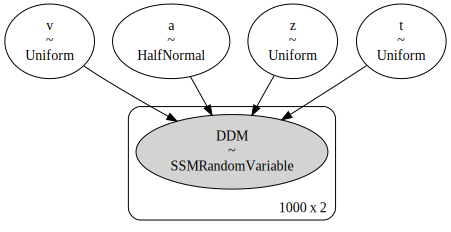

In [43]:
pm.model_to_graphviz(model=ddm_pymc)

Looks remarkably close to our HSSM version!

We can use PyMC directly to sample and finally return to ArviZ for some plotting!

In [44]:
with ddm_pymc:
    ddm_pymc_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, a, z, t]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 57 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


array([[<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'z'}>, <Axes: title={'center': 'z'}>],
       [<Axes: title={'center': 't'}>, <Axes: title={'center': 't'}>]],
      dtype=object)

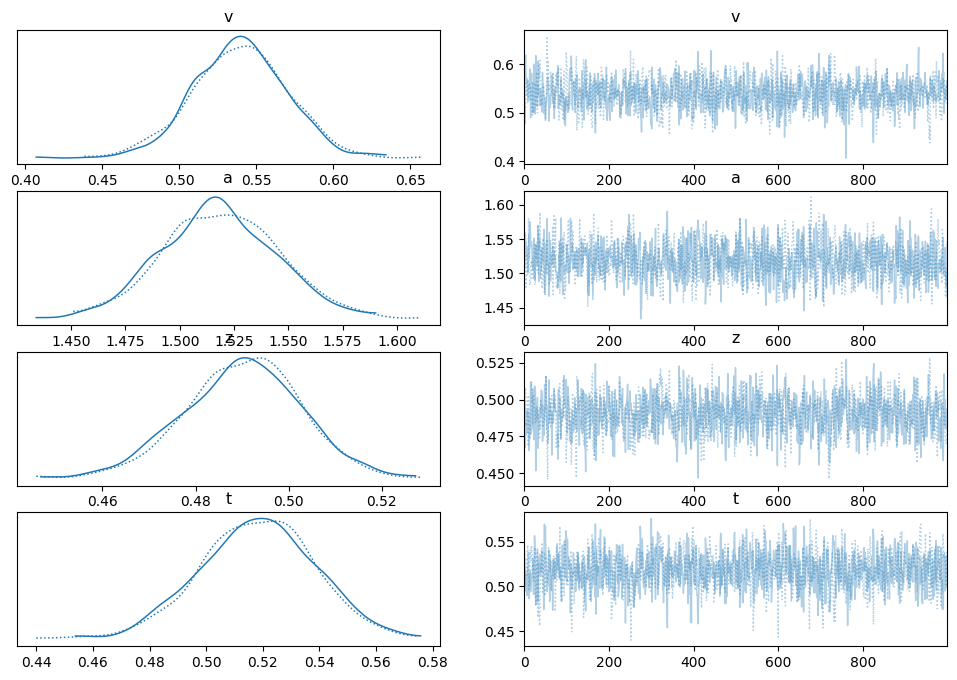

In [45]:
az.plot_trace(ddm_pymc_trace)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

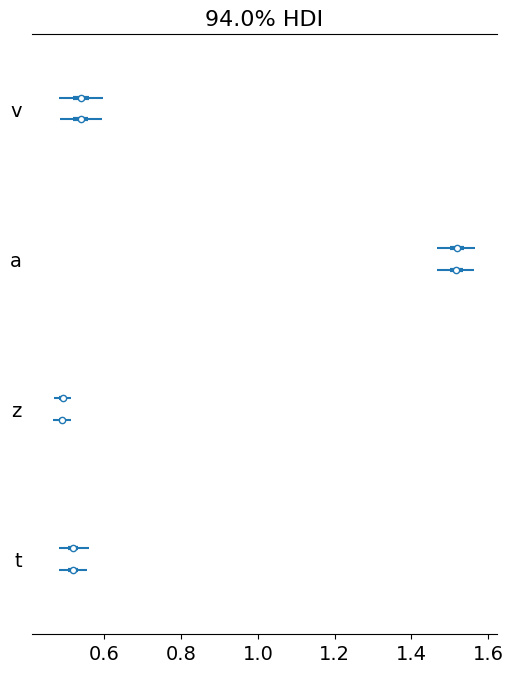

In [46]:
az.plot_forest(ddm_pymc_trace)

All layers peeled back, the only limit in your modeling endeavors becomes the limit of the PyMC universe!

<br> </br>

<center><img src="https://media.giphy.com/media/4ydWTcMBjimLbT1CHi/giphy.gif" style="margin:auto" height="300" width="300"/></center>


<center> Enjoy the exploration! </center>

# End